# Speech Recognation & Classification System

### This is a speech classification system using a Naïve Bayes classifier from scratch, compare its performance with built-in Logistic Regression, and enhance the results using bagging ensemble learning.

## Install Essential Libraries

In [79]:
"""
!pip install pyaudio
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install librosa
!pip install soundfile
!pip install pyaudio
!pip install scipy
!pip install scikit-learn
!pip install tqdm
!pip install ipython

"""

/bin/bash: line 1: pipx: command not found
/bin/bash: line 1: pipx: command not found
/bin/bash: line 1: pipx: command not found
/bin/bash: line 1: pipx: command not found
/bin/bash: line 1: pipx: command not found
/bin/bash: line 1: pipx: command not found
/bin/bash: line 1: pipx: command not found
/bin/bash: line 1: pipx: command not found
/bin/bash: line 1: pipx: command not found
/bin/bash: line 1: pipx: command not found
/bin/bash: line 1: pipx: command not found
/bin/bash: line 1: pipx: command not found


## Import Required Libraries

In [66]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import soundfile as sf
import random
import math
#import pyaudio
import wave
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tqdm import tqdm
from IPython.display import Audio, display

## Load The Dataset and Viualize Classes

In [67]:
# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)


# Define the dataset path
DATASET_PATH = '/kaggle/input/speech-commands-v2'


# Dataset Loader Function
class SpeechDatasetLoader:
    def __init__(self, dataset_path, classes=['yes', 'no'], max_samples_per_class=1000):
        self.dataset_path = dataset_path
        self.classes = classes
        self.max_samples_per_class = max_samples_per_class

    def load_data(self):
        """Load audio files from specified classes"""
        data = []
    
        print(f"Loading data for classes: {self.classes}")
        
        for label in self.classes:
          class_path = os.path.join(self.dataset_path, label)
          if not os.path.isdir(class_path):
            print(f"Warning: Path {class_path} not found")
            continue
        
          files = os.listdir(class_path)
          # Limit the number of samples per class if needed
          if len(files) > self.max_samples_per_class:
            files = random.sample(files, self.max_samples_per_class)
        
          print(f"Loading {len(files)} samples for class '{label}'")
        
          for file in tqdm(files):
            file_path = os.path.join(class_path, file)
            data.append((file_path, label))
    
        return data
    
    
    # Dataset Describe Function
    def describe_dataset(self, data):
        """Provide a description of the dataset"""
        labels = [label for _, label in data]
        class_distribution = {cls: labels.count(cls) for cls in self.classes}
        
        print("\nDataset Description:")
        print(f"Total samples: {len(data)}")
        print(f"Classes: {self.classes}")
        print("Class distribution:")
        for cls, count in class_distribution.items():
          print(f"  - {cls}: {count} samples ({count/len(data)*100:.2f}%)")
        
        # Get duration information from a subset of samples
        durations = []
        for i, (file_path, _) in enumerate(random.sample(data, min(100, len(data)))):
          y, sr = librosa.load(file_path, sr=None)
          durations.append(len(y) / sr)
        
        print(
            f"\nAudio characteristics (based on sample of {len(durations)} files):")
        print(f"  - Average duration: {np.mean(durations):.2f} seconds")
        print(f"  - Min duration: {np.min(durations):.2f} seconds")
        print(f"  - Max duration: {np.max(durations):.2f} seconds")
    
    
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        plt.bar(class_distribution.keys(), class_distribution.values())
        plt.title('Class Distribution')
        plt.xlabel('Class')
        plt.ylabel('Number of Samples')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        
        # Plot duration histogram
        plt.figure(figsize=(10, 6))
        plt.hist(durations, bins=20)
        plt.title('Audio Duration Distribution')
        plt.xlabel('Duration (seconds)')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()
    
        return class_distribution

## Audio Prerocessing Class

In [68]:
class AudioPreprocessor:
  def __init__(self, sr=16000, duration=1.0):
    self.sr = sr  # Target sample rate
    self.duration = duration  # Target duration in seconds

  def preprocess(self, file_path):
    """Preprocess a single audio file"""
    # Load audio file
    y, sr = librosa.load(file_path, sr=self.sr)

    # Noise reduction using spectral gating
    y = self._reduce_noise(y)

    # Remove silence
    y = self._remove_silence(y)

    # Normalize the signal
    y = self._normalize(y)

    # Pad or trim to fixed duration
    target_length = int(self.sr * self.duration)
    if len(y) < target_length:
      # Pad with zeros if too short
      y = np.pad(y, (0, target_length - len(y)))
    else:
      # Trim if too long
      y = y[:target_length]

    return y, sr

  def _reduce_noise(self, y):
    """Simple noise reduction using spectral gating"""
    # Calculate noise profile from the lowest energy sections
    frame_length = 2048
    hop_length = 512

    # Compute spectrogram
    D = librosa.stft(y, n_fft=frame_length, hop_length=hop_length)
    D_mag = np.abs(D)

    # Estimate noise profile from low energy frames
    n_frames = D_mag.shape[1]
    frame_energies = np.sum(D_mag**2, axis=0)
    low_energy_threshold = np.percentile(frame_energies, 20)
    noise_frames = frame_energies < low_energy_threshold

    if np.any(noise_frames):
      noise_profile = np.mean(D_mag[:, noise_frames], axis=1)
      noise_profile = noise_profile.reshape(-1, 1)

      # Apply simple spectral subtraction
      gain = np.maximum(0, D_mag - 2 * noise_profile)

      # Reconstruct signal
      D_denoised = gain * np.exp(1j * np.angle(D))
      y_denoised = librosa.istft(D_denoised, hop_length=hop_length)

      # Make sure the output has the same length as input
      y_denoised = y_denoised[:len(y)] if len(y_denoised) >= len(
          y) else np.pad(y_denoised, (0, len(y) - len(y_denoised)))

      return y_denoised
    else:
      return y

  def _remove_silence(self, y, threshold=0.03, frame_length=1024):
    """Remove silence portions from audio"""
    # Calculate energy of each frame
    frame_energies = librosa.feature.rms(
        y=y, frame_length=frame_length, hop_length=frame_length//2)[0]

    # Find frames with energy above threshold
    active_frames = frame_energies > threshold

    if not np.any(active_frames):
      # If no active frames found, return the original signal
      return y

    # Find the first and last active frame
    first_active = np.where(active_frames)[0][0]
    last_active = np.where(active_frames)[0][-1]

    # Convert frame indices to sample indices
    first_sample = max(0, first_active * (frame_length//2))
    last_sample = min(len(y), (last_active + 1) * (frame_length//2))

    # Extract active region
    return y[first_sample:last_sample]

  def _normalize(self, y):
    """Normalize audio to [-1, 1] range"""
    if np.max(np.abs(y)) > 0:
      return y / np.max(np.abs(y))
    else:
      return y

  def visualize_preprocessing(self, file_path):
    """Visualize the preprocessing steps for a given audio file"""
    # Load original audio
    y_orig, sr = librosa.load(file_path, sr=self.sr)

    # Apply preprocessing steps one by one
    y_noise_reduced = self._reduce_noise(y_orig)
    y_silence_removed = self._remove_silence(y_noise_reduced)
    y_normalized = self._normalize(y_silence_removed)

    # Final preprocessed audio
    y_final, sr = self.preprocess(file_path)

    # Plot the waveforms
    plt.figure(figsize=(15, 12))

    plt.subplot(5, 1, 1)
    plt.title("Original Audio")
    plt.plot(y_orig)
    plt.xlim([0, len(y_orig)])

    plt.subplot(5, 1, 2)
    plt.title("After Noise Reduction")
    plt.plot(y_noise_reduced)
    plt.xlim([0, len(y_noise_reduced)])

    plt.subplot(5, 1, 3)
    plt.title("After Silence Removal")
    plt.plot(y_silence_removed)
    plt.xlim([0, len(y_silence_removed)])

    plt.subplot(5, 1, 4)
    plt.title("After Normalization")
    plt.plot(y_normalized)
    plt.xlim([0, len(y_normalized)])

    plt.subplot(5, 1, 5)
    plt.title("Final Preprocessed Audio (Fixed Duration)")
    plt.plot(y_final)
    plt.xlim([0, len(y_final)])

    plt.tight_layout()
    plt.show()

    # Plot spectrograms
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.title("Original Spectrogram")
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y_orig)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')

    plt.subplot(2, 2, 2)
    plt.title("After Noise Reduction")
    D = librosa.amplitude_to_db(
        np.abs(librosa.stft(y_noise_reduced)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')

    plt.subplot(2, 2, 3)
    plt.title("After Silence Removal")
    D = librosa.amplitude_to_db(
        np.abs(librosa.stft(y_silence_removed)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')

    plt.subplot(2, 2, 4)
    plt.title("Final Processed Audio")
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y_final)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

    # Play original and processed audio
    print("Original Audio:")
    display(Audio(y_orig, rate=sr))

    print("Processed Audio:")
    display(Audio(y_final, rate=sr))

    return y_final, sr

## Feature Extractor Class

In [69]:
class FeatureExtractor:
  def __init__(self, sr=16000):
    self.sr = sr

  def extract_features(self, y, sr):
    """Extract various audio features from preprocessed audio"""
    # Initialize feature dictionary
    features = {}

    # 1. MFCCs (Mel-Frequency Cepstral Coefficients)
    n_mfcc = 13
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    for i in range(n_mfcc):
      features[f'mfcc_{i+1}_mean'] = np.mean(mfccs[i])
      features[f'mfcc_{i+1}_std'] = np.std(mfccs[i])

    # 2. Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    features['spectral_centroid_mean'] = np.mean(spectral_centroid)
    features['spectral_centroid_std'] = np.std(spectral_centroid)

    # 3. Spectral Rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
    features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
    features['spectral_rolloff_std'] = np.std(spectral_rolloff)

    # 4. Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)[0]
    features['zcr_mean'] = np.mean(zcr)
    features['zcr_std'] = np.std(zcr)

    # 5. Root Mean Square Energy
    rms = librosa.feature.rms(y=y)[0]
    features['rms_mean'] = np.mean(rms)
    features['rms_std'] = np.std(rms)

    # 6. Spectral Bandwidth
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
    features['bandwidth_mean'] = np.mean(bandwidth)
    features['bandwidth_std'] = np.std(bandwidth)

    # 7. Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    features['contrast_mean'] = np.mean(contrast)
    features['contrast_std'] = np.std(contrast)

    # 8. Chroma Features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features['chroma_mean'] = np.mean(chroma)
    features['chroma_std'] = np.std(chroma)

    # 9. Tempo and Beat Features
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    features['tempo'] = tempo

    return features

  def extract_features_batch(self, audio_data):
    """Extract features for a batch of preprocessed audio files"""
    features_list = []
    labels = []

    print("Extracting features from audio files...")
    for audio, label in tqdm(audio_data):
      features = self.extract_features(audio, self.sr)
      features_list.append(features)
      labels.append(label)

    # Convert to DataFrame
    df = pd.DataFrame(features_list)

    return df, labels

  def visualize_features(self, df, labels):
    """Visualize extracted features"""
    # Convert labels to numeric for coloring
    unique_labels = list(set(labels))
    label_map = {label: i for i, label in enumerate(unique_labels)}
    numeric_labels = [label_map[label] for label in labels]

    # 1. Box plot of selected features
    selected_features = ['mfcc_1_mean', 'mfcc_2_mean',
                         'spectral_centroid_mean', 'zcr_mean', 'rms_mean']
    plt.figure(figsize=(15, 8))

    df_plot = df[selected_features].copy()
    df_plot['label'] = labels

    df_melted = pd.melt(
        df_plot, id_vars=['label'], value_vars=selected_features)

    sns.boxplot(x='variable', y='value', hue='label', data=df_melted)
    plt.title('Distribution of Key Features by Class')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 2. Feature correlation heatmap
    plt.figure(figsize=(14, 12))
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0,
                square=True, linewidths=.5, annot=False)
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.show()

    # 3. PCA visualization
    from sklearn.decomposition import PCA

    # Standardize features
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    # Apply PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(df_scaled)

    # Create DataFrame with principal components
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    pca_df['label'] = labels

    # Plot PCA
    plt.figure(figsize=(10, 8))
    for label in unique_labels:
      subset = pca_df[pca_df['label'] == label]
      plt.scatter(subset['PC1'], subset['PC2'], label=label, alpha=0.7)

    plt.title('PCA of Audio Features')
    plt.xlabel(
        f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(
        f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    return label_map

## Gaussian Naive Bayes Classifier

In [70]:

class GaussianNaiveBayes:
  def __init__(self):
    self.classes = None
    self.class_priors = {}
    self.class_means = {}
    self.class_vars = {}
    self.smoothing = 1e-9  # Smoothing parameter to handle zero variance
    self.feature_names = None

  def fit(self, X, y):
    """Train the Gaussian Naive Bayes classifier"""
    if isinstance(X, pd.DataFrame):
      self.feature_names = X.columns
      X = X.values

    n_samples, n_features = X.shape
    self.classes = np.unique(y)

    # Calculate class priors (probability of each class)
    for c in self.classes:
      self.class_priors[c] = np.mean(np.array(y) == c)

    # Calculate mean and variance for each feature in each class
    for c in self.classes:
      X_c = X[np.array(y) == c]
      self.class_means[c] = np.mean(X_c, axis=0)
      self.class_vars[c] = np.var(X_c, axis=0) + self.smoothing

  def _calculate_likelihood(self, x, mean, var):
    """Calculate the Gaussian likelihood P(x|mean,var)"""
    exponent = np.exp(-((x - mean) ** 2) / (2 * var))
    return exponent / np.sqrt(2 * np.pi * var)

  def _calculate_class_probability(self, x, c):
    """Calculate the class probability P(c|x) for a single sample"""
    # Get the class prior probability
    log_prior = np.log(self.class_priors[c])

    # Calculate the log likelihood for each feature
    log_likelihood = np.sum(np.log(self._calculate_likelihood(
        x, self.class_means[c], self.class_vars[c])))

    # Return the log posterior (unnormalized)
    return log_prior + log_likelihood

  def predict_proba(self, X):
    """Predict class probabilities for samples in X"""
    if isinstance(X, pd.DataFrame):
      X = X.values

    n_samples = X.shape[0]
    n_classes = len(self.classes)

    # Initialize the probability matrix
    probs = np.zeros((n_samples, n_classes))

    # Calculate the log probability for each class
    for i, c in enumerate(self.classes):
      for j, x in enumerate(X):
        probs[j, i] = self._calculate_class_probability(x, c)

    # Normalize to get probabilities (using softmax)
    # First, subtract max for numerical stability
    probs_exp = np.exp(probs - np.max(probs, axis=1, keepdims=True))
    probs_norm = probs_exp / np.sum(probs_exp, axis=1, keepdims=True)

    return probs_norm

  def predict(self, X):
    """Predict the class label for samples in X"""
    probs = self.predict_proba(X)
    return np.array([self.classes[np.argmax(p)] for p in probs])

  def score(self, X, y):
    """Calculate the accuracy of predictions"""
    y_pred = self.predict(X)
    return np.mean(y_pred == y)

  def visualize_model(self, X, y):
    """Visualize the model's feature distributions and decision boundaries"""
    if isinstance(X, pd.DataFrame):
      feature_names = X.columns
      X = X.values
    else:
      feature_names = [f"Feature {i}" for i in range(X.shape[1])]

    # 1. Visualize feature distributions by class for the first few features
    plt.figure(figsize=(15, 10))
    for i, c in enumerate(self.classes):
      for j, feature_idx in enumerate(range(min(4, X.shape[1]))):
        plt.subplot(len(self.classes), 4, i*4 + j + 1)

        # Get feature values for this class
        X_c = X[np.array(y) == c]
        feature_values = X_c[:, feature_idx]

        # Plot histogram of feature values
        plt.hist(feature_values, bins=20, alpha=0.5,
                 density=True, label=f"Data - {c}")

        # Plot the fitted Gaussian distribution
        x_range = np.linspace(min(feature_values), max(feature_values), 1000)
        gaussian = norm.pdf(x_range, self.class_means[c][feature_idx],
                            np.sqrt(self.class_vars[c][feature_idx]))
        plt.plot(x_range, gaussian, 'r-', linewidth=2, label=f"Gaussian - {c}")

        if i == 0:
          plt.title(feature_names[feature_idx])
        if j == 0:
          plt.ylabel(f"Class {c}")
        if i == len(self.classes) - 1:
          plt.xlabel("Value")

        plt.grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 2. Feature importance based on class separability
    if X.shape[1] > 1:  # Only if we have at least 2 features
      feature_importance = {}

      # Measure separability using Bhattacharyya distance
      for feature_idx in range(X.shape[1]):
        mean_diffs = []
        var_ratios = []

        for i, c1 in enumerate(self.classes):
          for c2 in self.classes[i+1:]:
            # Difference in means
            mean_diff = (
                self.class_means[c1][feature_idx] - self.class_means[c2][feature_idx])**2
            mean_diffs.append(mean_diff)

            # Ratio of variances
            var_ratio = self.class_vars[c1][feature_idx] / \
                self.class_vars[c2][feature_idx]
            var_ratios.append(var_ratio)

        importance = np.mean(mean_diffs) * \
            (1 + np.mean([max(v, 1/v) for v in var_ratios]))
        feature_importance[feature_names[feature_idx]] = importance

      # Normalize importance scores
      max_importance = max(feature_importance.values())
      for feature in feature_importance:
        feature_importance[feature] /= max_importance

      # Plot feature importance
      plt.figure(figsize=(12, 6))
      features = list(feature_importance.keys())
      importances = list(feature_importance.values())

      # Sort by importance
      sorted_indices = np.argsort(importances)
      sorted_features = [features[i] for i in sorted_indices]
      sorted_importances = [importances[i] for i in sorted_indices]

      plt.barh(sorted_features, sorted_importances, color='skyblue')
      plt.title('Feature Importance based on Class Separability')
      plt.xlabel('Normalized Importance')
      plt.grid(True, linestyle='--', alpha=0.3)
      plt.tight_layout()
      plt.show()

    # 3. Visualize decision boundaries if we have only 2 features
    if X.shape[1] == 2:
      x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
      y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
      xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                           np.arange(y_min, y_max, 0.1))

      Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
      Z = np.array([self.classes.tolist().index(z) for z in Z])
      Z = Z.reshape(xx.shape)

      plt.figure(figsize=(10, 8))
      plt.contourf(xx, yy, Z, alpha=0.4)

      for i, c in enumerate(self.classes):
        plt.scatter(X[np.array(y) == c, 0], X[np.array(y) == c, 1],
                    label=c, edgecolors='k')

      plt.title('Decision Boundaries')
      plt.xlabel(feature_names[0])
      plt.ylabel(feature_names[1])
      plt.legend()
      plt.tight_layout()
      plt.show()

## Bagging Classifier

In [71]:
class BaggingClassifier:
  def __init__(self, base_classifier, n_estimators=10, sample_ratio=0.8, random_state=None):
    self.base_classifier = base_classifier
    self.n_estimators = n_estimators
    self.sample_ratio = sample_ratio
    self.random_state = random_state
    self.estimators = []

  def fit(self, X, y):
    """Train multiple base classifiers on bootstrap samples"""
    if isinstance(X, pd.DataFrame):
      X = X.values

    n_samples = X.shape[0]
    n_bootstrap_samples = int(n_samples * self.sample_ratio)

    # Set random seed if specified
    if self.random_state is not None:
      np.random.seed(self.random_state)

    print(f"Training {self.n_estimators} models for bagging...")
    for i in tqdm(range(self.n_estimators)):
      # Generate bootstrap sample
      indices = np.random.choice(n_samples, n_bootstrap_samples, replace=True)
      X_bootstrap = X[indices]
      y_bootstrap = [y[i] for i in indices]

      # Train a new classifier on bootstrap sample
      classifier = self.base_classifier()
      classifier.fit(X_bootstrap, y_bootstrap)

      # Add to ensemble
      self.estimators.append(classifier)

    return self

  def predict(self, X):
    """Predict using majority voting from all base classifiers"""
    if isinstance(X, pd.DataFrame):
      X = X.values

    predictions = np.array([estimator.predict(X)
                           for estimator in self.estimators])

    # Transpose to get predictions per sample
    predictions = predictions.T

    # Perform majority voting
    final_predictions = []
    for pred_set in predictions:
      # Count occurrences of each class
      unique_classes, counts = np.unique(pred_set, return_counts=True)
      # Find the class with the most votes
      majority_class = unique_classes[np.argmax(counts)]
      final_predictions.append(majority_class)

    return np.array(final_predictions)

  def predict_proba(self, X):
    """Predict class probabilities by averaging probabilities from all base classifiers"""
    if isinstance(X, pd.DataFrame):
      X = X.values

    # Get probabilities from each classifier
    all_probs = []
    for estimator in self.estimators:
      if hasattr(estimator, 'predict_proba'):
        probs = estimator.predict_proba(X)
        all_probs.append(probs)

    # Average the probabilities
    if all_probs:
      return np.mean(all_probs, axis=0)
    else:
      return None

## Logistic Regression from Scratch

In [72]:
class LogisticRegressionFromScratch:
  def __init__(self, learning_rate=0.01, iterations=1000, random_state=None):
    self.learning_rate = learning_rate
    self.iterations = iterations
    self.random_state = random_state
    self.weights = None
    self.bias = None
    self.classes = None

  def _sigmoid(self, z):
    """Sigmoid activation function"""
    return 1 / (1 + np.exp(-z))

  def fit(self, X, y):
    """Train the logistic regression model"""
    if isinstance(X, pd.DataFrame):
      X = X.values

    # Set random seed if specified
    if self.random_state is not None:
      np.random.seed(self.random_state)

    n_samples, n_features = X.shape
    self.weights = np.random.randn(n_features)
    self.bias = 0

    # Identify unique classes
    self.classes = np.unique(y)

    # If binary classification
    if len(self.classes) == 2:
      # Convert labels to 0 and 1
      y_binary = np.array(
          [1 if label == self.classes[1] else 0 for label in y])

      # Gradient descent
      for _ in range(self.iterations):
        # Linear model: z = X · weights + bias
        z = np.dot(X, self.weights) + self.bias

        # Sigmoid activation
        y_pred = self._sigmoid(z)

        # Compute gradients
        dw = (1/n_samples) * np.dot(X.T, (y_pred - y_binary))
        db = (1/n_samples) * np.sum(y_pred - y_binary)

        # Update parameters
        self.weights -= self.learning_rate * dw
        self.bias -= self.learning_rate * db
    else:
      # For multi-class, implement one-vs-rest approach
      self.weights = np.zeros((len(self.classes), n_features))
      self.bias = np.zeros(len(self.classes))

      for i, c in enumerate(self.classes):
        # Convert to binary classification problem
        y_binary = np.array([1 if label == c else 0 for label in y])

        # Initialize weights for this class
        weights_c = np.random.randn(n_features)
        bias_c = 0

        # Gradient descent for this class
        for _ in range(self.iterations):
          # Linear model
          z = np.dot(X, weights_c) + bias_c

          # Sigmoid activation
          y_pred = self._sigmoid(z)

          # Compute gradients
          dw = (1/n_samples) * np.dot(X.T, (y_pred - y_binary))
          db = (1/n_samples) * np.sum(y_pred - y_binary)

          # Update parameters
          weights_c -= self.learning_rate * dw
          bias_c -= self.learning_rate * db

        # Store weights and bias for this class
        self.weights[i] = weights_c
        self.bias[i] = bias_c

    return self

  def predict_proba(self, X):
    """Predict class probabilities"""
    if isinstance(X, pd.DataFrame):
      X = X.values

    n_samples = X.shape[0]

    if len(self.classes) == 2:
      # Binary classification
      z = np.dot(X, self.weights) + self.bias
      y_pred = self._sigmoid(z)

      # Return probabilities for both classes
      return np.column_stack((1 - y_pred, y_pred))
    else:
      # Multi-class classification
      probas = np.zeros((n_samples, len(self.classes)))

      for i, _ in enumerate(self.classes):
        z = np.dot(X, self.weights[i]) + self.bias[i]
        probas[:, i] = self._sigmoid(z)

      # Normalize probabilities
      probas = probas / np.sum(probas, axis=1, keepdims=True)

      return probas

  def predict(self, X):
    """Predict class labels"""
    probas = self.predict_proba(X)
    return self.classes[np.argmax(probas, axis=1)]

## Speech Recognition System

In [73]:
class SpeechRecognitionSystem:
  def __init__(self, dataset_path, classes=['yes', 'no'], max_samples_per_class=1000):
    self.dataset_path = dataset_path
    self.classes = classes
    self.max_samples_per_class = max_samples_per_class

    # Initialize components
    self.loader = SpeechDatasetLoader(
        dataset_path, classes, max_samples_per_class)
    self.preprocessor = AudioPreprocessor()
    self.feature_extractor = FeatureExtractor()

    # Models
    self.nb_model = None
    self.nb_bagging_model = None
    self.lr_model = None
    self.lr_bagging_model = None

    # Scalers for normalization
    self.scaler = StandardScaler()

    # Data
    self.X_train = None
    self.X_test = None
    self.y_train = None
    self.y_test = None

  def load_and_preprocess_data(self):
    """Load, preprocess data and extract features"""
    # Load data
    data = self.loader.load_data()

    # Describe dataset
    self.loader.describe_dataset(data)

    # Preprocess audio files
    processed_data = []

    print("\nPreprocessing audio files...")
    for file_path, label in tqdm(data):
      # Apply preprocessing
      y, sr = self.preprocessor.preprocess(file_path)
      processed_data.append((y, label))

    # Visualize preprocessing for a random sample
    random_idx = random.randint(0, len(data) - 1)
    print(
        f"\nVisualizing preprocessing for a random {data[random_idx][1]} sample:")
    self.preprocessor.visualize_preprocessing(data[random_idx][0])

    # Extract features
    features_df, labels = self.feature_extractor.extract_features_batch(
        processed_data)

    # Visualize features
    print("\nVisualizing extracted features:")
    self.feature_extractor.visualize_features(features_df, labels)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        features_df, labels, test_size=0.2, random_state=42, stratify=labels
    )

    # Scale features
    self.X_train = pd.DataFrame(
        self.scaler.fit_transform(X_train), columns=X_train.columns)
    self.X_test = pd.DataFrame(
        self.scaler.transform(X_test), columns=X_test.columns)
    self.y_train = y_train
    self.y_test = y_test

    print(
        f"\nData split: {len(y_train)} training samples, {len(y_test)} testing samples")

  def train_models(self, n_estimators=10):
    """Train all models"""
    if self.X_train is None:
      raise ValueError(
          "Data not loaded. Call load_and_preprocess_data() first.")

    print("\n1. Training Naive Bayes Classifier from scratch...")
    self.nb_model = GaussianNaiveBayes()
    self.nb_model.fit(self.X_train, self.y_train)

    print("\n2. Training Bagging with Naive Bayes...")
    self.nb_bagging_model = BaggingClassifier(
        base_classifier=GaussianNaiveBayes,
        n_estimators=n_estimators,
        random_state=42
    )
    self.nb_bagging_model.fit(self.X_train, self.y_train)

    print("\n3. Training Logistic Regression from scratch...")
    self.lr_model = LogisticRegressionFromScratch(
        iterations=1000, random_state=42)
    self.lr_model.fit(self.X_train, self.y_train)

    print("\n4. Training Bagging with Logistic Regression...")
    self.lr_bagging_model = BaggingClassifier(
        base_classifier=lambda: LogisticRegressionFromScratch(
            iterations=1000, random_state=None),
        n_estimators=n_estimators,
        random_state=42
    )
    self.lr_bagging_model.fit(self.X_train, self.y_train)

  def evaluate_models(self):
    """Evaluate all models and compare performance"""
    if self.nb_model is None:
      raise ValueError("Models not trained. Call train_models() first.")

    models = {
        "Naive Bayes": self.nb_model,
        "Bagging with Naive Bayes": self.nb_bagging_model,
        "Logistic Regression": self.lr_model,
        "Bagging with Logistic Regression": self.lr_bagging_model
    }

    results = {}

    for name, model in models.items():
      print(f"\nEvaluating {name}...")

      # Predict on test set
      y_pred = model.predict(self.X_test)

      # Calculate metrics
      accuracy = accuracy_score(self.y_test, y_pred)
      precision = precision_score(self.y_test, y_pred, average='weighted')
      recall = recall_score(self.y_test, y_pred, average='weighted')
      f1 = f1_score(self.y_test, y_pred, average='weighted')

      # Store results
      results[name] = {
          'accuracy': accuracy,
          'precision': precision,
          'recall': recall,
          'f1': f1
      }

      # Print metrics
      print(f"Accuracy: {accuracy:.4f}")
      print(f"Precision: {precision:.4f}")
      print(f"Recall: {recall:.4f}")
      print(f"F1 Score: {f1:.4f}")

      # Print confusion matrix
      print("\nConfusion Matrix:")
      cm = confusion_matrix(self.y_test, y_pred)
      print(cm)

      # Plot confusion matrix
      plt.figure(figsize=(8, 6))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                  xticklabels=self.classes, yticklabels=self.classes)
      plt.title(f'Confusion Matrix - {name}')
      plt.ylabel('True Label')
      plt.xlabel('Predicted Label')
      plt.tight_layout()
      plt.show()

      # Print classification report
      print("\nClassification Report:")
      print(classification_report(self.y_test, y_pred))

    # Visualize model comparison
    self._visualize_model_comparison(results)

    # Visualize Naive Bayes model
    print("\nVisualizing Naive Bayes model...")
    self.nb_model.visualize_model(self.X_train, self.y_train)

    return results

  def _visualize_model_comparison(self, results):
    """Visualize model comparison using various plots"""
    # 1. Bar plot for accuracy comparison
    plt.figure(figsize=(12, 6))

    model_names = list(results.keys())
    accuracies = [results[name]['accuracy'] for name in model_names]

    plt.bar(model_names, accuracies, color=[
            'skyblue', 'royalblue', 'lightgreen', 'forestgreen'])
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.xticks(rotation=15)

    # Add accuracy values on top of bars
    for i, v in enumerate(accuracies):
      plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

    plt.tight_layout()
    plt.show()

    # 2. Radar chart for multiple metrics
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    # Create a figure
    fig = plt.figure(figsize=(10, 8))

    # Adjust layout to make more room
    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9)

    # Set up the radar chart
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Close the polygon

    ax = fig.add_subplot(111, polar=True)

    # Add metric labels
    plt.xticks(angles[:-1], metrics)

    # Plot each model
    colors = ['skyblue', 'royalblue', 'lightgreen', 'forestgreen']
    for i, (name, color) in enumerate(zip(model_names, colors)):
      values = [results[name][metric] for metric in metrics]
      values += values[:1]  # Close the polygon

      ax.plot(angles, values, 'o-', linewidth=2, label=name, color=color)
      ax.fill(angles, values, alpha=0.1, color=color)

    plt.title('Model Performance Comparison')
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

    # 3. Comparison of base vs bagging performance
    plt.figure(figsize=(12, 6))

    # Prepare data for comparison
    base_models = ["Naive Bayes", "Logistic Regression"]
    bagging_models = ["Bagging with Naive Bayes",
                      "Bagging with Logistic Regression"]

    x = np.arange(len(base_models))
    width = 0.35

    base_accuracies = [results[model]['accuracy'] for model in base_models]
    bagging_accuracies = [results[model]['accuracy']
                          for model in bagging_models]

    plt.bar(x - width/2, base_accuracies, width,
            label='Base Model', color='lightcoral')
    plt.bar(x + width/2, bagging_accuracies, width,
            label='With Bagging', color='lightseagreen')

    plt.title('Impact of Bagging on Model Performance')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.xticks(x, base_models)
    plt.legend()

    # Add accuracy improvement percentage
    for i in range(len(base_models)):
      improvement = (
          (bagging_accuracies[i] - base_accuracies[i]) / base_accuracies[i]) * 100
      plt.annotate(f'{improvement:.2f}%',
                   xy=(i, max(base_accuracies[i],
                       bagging_accuracies[i]) + 0.02),
                   ha='center', va='bottom',
                   color='black' if improvement >= 0 else 'red')

    plt.tight_layout()
    plt.show()

  def record_audio(self, duration=1, fs=16000):
    """Record audio from microphone"""
    print(f"Recording for {duration} seconds...")

    # Initialize PyAudio
    p = pyaudio.PyAudio()

    # Open stream
    stream = p.open(format=pyaudio.paInt16,
                    channels=1,
                    rate=fs,
                    input=True,
                    frames_per_buffer=1024)

    # Record audio
    frames = []
    for _ in range(0, int(fs / 1024 * duration)):
      data = stream.read(1024)
      frames.append(data)

    # Stop and close the stream
    stream.stop_stream()
    stream.close()
    p.terminate()

    print("Recording finished")

    # Convert to numpy array
    audio_data = np.frombuffer(b''.join(frames), dtype=np.int16)

    # Normalize to float
    audio_data = audio_data.astype(np.float32) / 32768.0

    return audio_data, fs

  def save_audio(self, audio_data, fs, file_path="recorded_audio.wav"):
    """Save audio data to WAV file"""
    # Convert back to int16
    audio_data = (audio_data * 32768.0).astype(np.int16)

    # Save as WAV file
    with wave.open(file_path, 'wb') as wf:
      wf.setnchannels(1)
      wf.setsampwidth(2)  # 2 bytes (16 bits)
      wf.setframerate(fs)
      wf.writeframes(audio_data.tobytes())

    print(f"Audio saved to {file_path}")

  def predict_audio(self, audio_data, fs, visualize=True):
    """Predict class for recorded or loaded audio"""
    if self.nb_model is None:
      raise ValueError("Models not trained. Call train_models() first.")

    # Preprocess audio
    preprocessed_audio = self.preprocessor._normalize(audio_data)
    preprocessed_audio = self.preprocessor._reduce_noise(preprocessed_audio)
    preprocessed_audio = self.preprocessor._remove_silence(preprocessed_audio)

    # Pad or trim to fixed duration
    target_length = int(fs * self.preprocessor.duration)
    if len(preprocessed_audio) < target_length:
      preprocessed_audio = np.pad(
          preprocessed_audio, (0, target_length - len(preprocessed_audio)))
    else:
      preprocessed_audio = preprocessed_audio[:target_length]

    # Extract features
    features = self.feature_extractor.extract_features(preprocessed_audio, fs)

    # Convert to DataFrame
    features_df = pd.DataFrame([features])

    # Scale features
    scaled_features = pd.DataFrame(self.scaler.transform(
        features_df), columns=features_df.columns)

    # Get predictions from all models
    predictions = {}
    probabilities = {}

    models = {
        "Naive Bayes": self.nb_model,
        "Bagging with Naive Bayes": self.nb_bagging_model,
        "Logistic Regression": self.lr_model,
        "Bagging with Logistic Regression": self.lr_bagging_model
    }

    for name, model in models.items():
      # Get prediction
      pred = model.predict(scaled_features)[0]
      predictions[name] = pred

      # Get probability if available
      if hasattr(model, 'predict_proba'):
        proba = model.predict_proba(scaled_features)[0]
        # Find index of predicted class
        class_idx = np.where(model.classes == pred)[
            0][0] if hasattr(model, 'classes') else 0
        # Get probability for predicted class
        probabilities[name] = proba[class_idx]

    # Print predictions
    print("\nPredictions:")
    for name, pred in predictions.items():
      prob = probabilities.get(name, "N/A")
      prob_str = f"{prob:.4f}" if isinstance(prob, (int, float)) else prob
      print(f"{name}: {pred} (Probability: {prob_str})")

    if visualize:
      # Visualize audio waveform and spectrogram
      plt.figure(figsize=(12, 8))

      plt.subplot(2, 1, 1)
      plt.title("Audio Waveform")
      plt.plot(preprocessed_audio)
      plt.xlabel("Sample")
      plt.ylabel("Amplitude")

      plt.subplot(2, 1, 2)
      plt.title("Spectrogram")
      D = librosa.amplitude_to_db(
          np.abs(librosa.stft(preprocessed_audio)), ref=np.max)
      librosa.display.specshow(D, sr=fs, x_axis='time', y_axis='log')
      plt.colorbar(format='%+2.0f dB')

      plt.tight_layout()
      plt.show()

      # Visualize prediction results
      plt.figure(figsize=(10, 6))

      models_list = list(predictions.keys())
      class_list = list(predictions.values())

      # Create bar colors based on classes
      unique_classes = list(set(class_list))
      class_colors = {cls: plt.cm.tab10(i)
                      for i, cls in enumerate(unique_classes)}
      colors = [class_colors[cls] for cls in class_list]

      plt.bar(models_list, [1] * len(models_list), color=colors)
      plt.xticks(rotation=45)
      plt.title("Model Predictions")
      plt.tight_layout()

      # Add class labels
      for i, (model, cls) in enumerate(zip(models_list, class_list)):
        plt.text(i, 0.5, cls, ha='center', va='center',
                 fontsize=12, color='white', fontweight='bold')

      # Add legend
      handles = [plt.Rectangle((0, 0), 1, 1, color=class_colors[cls])
                 for cls in unique_classes]
      plt.legend(handles, unique_classes, title="Predicted Class")

      plt.tight_layout()
      plt.show()

    return predictions, probabilities

  def load_audio(self, file_path):
    """Load audio from a file"""
    y, sr = librosa.load(file_path, sr=None)
    return y, sr

  def run_from_file(self, file_path):
    """Run the system on an audio file"""
    # Load audio
    audio_data, fs = self.load_audio(file_path)

    # Play audio
    print("Playing audio...")
    display(Audio(audio_data, rate=fs))

    # Predict
    predictions, probabilities = self.predict_audio(audio_data, fs)

    return predictions, probabilities

  def run_live(self, duration=1):
    """Run the system with live microphone input"""
    # Record audio
    audio_data, fs = self.record_audio(duration=duration)

    # Save audio
    self.save_audio(audio_data, fs)

    # Play audio
    print("Playing recorded audio...")
    display(Audio(audio_data, rate=fs))

    # Predict
    predictions, probabilities = self.predict_audio(audio_data, fs)

    return predictions, probabilities



## Create Speech Recognation System and apply Data Preprocessing

In [74]:
system = SpeechRecognitionSystem(
    dataset_path=DATASET_PATH,
    classes=['yes', 'no'],  # Binary classification
    max_samples_per_class=1000  # Limit samples for faster execution
)

### Load, preprocess data and extract features

Loading data for classes: ['yes', 'no']
Loading 1000 samples for class 'yes'


100%|██████████| 1000/1000 [00:00<00:00, 538559.84it/s]


Loading 1000 samples for class 'no'


100%|██████████| 1000/1000 [00:00<00:00, 502853.85it/s]


Dataset Description:
Total samples: 2000
Classes: ['yes', 'no']
Class distribution:
  - yes: 1000 samples (50.00%)
  - no: 1000 samples (50.00%)



Audio characteristics (based on sample of 100 files):
  - Average duration: 0.98 seconds
  - Min duration: 0.70 seconds
  - Max duration: 1.00 seconds


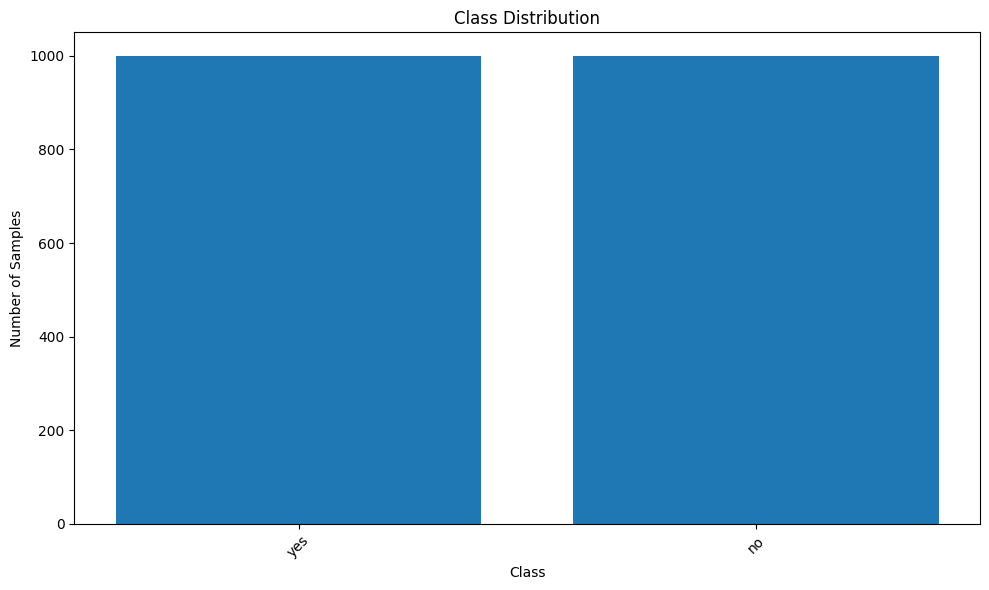

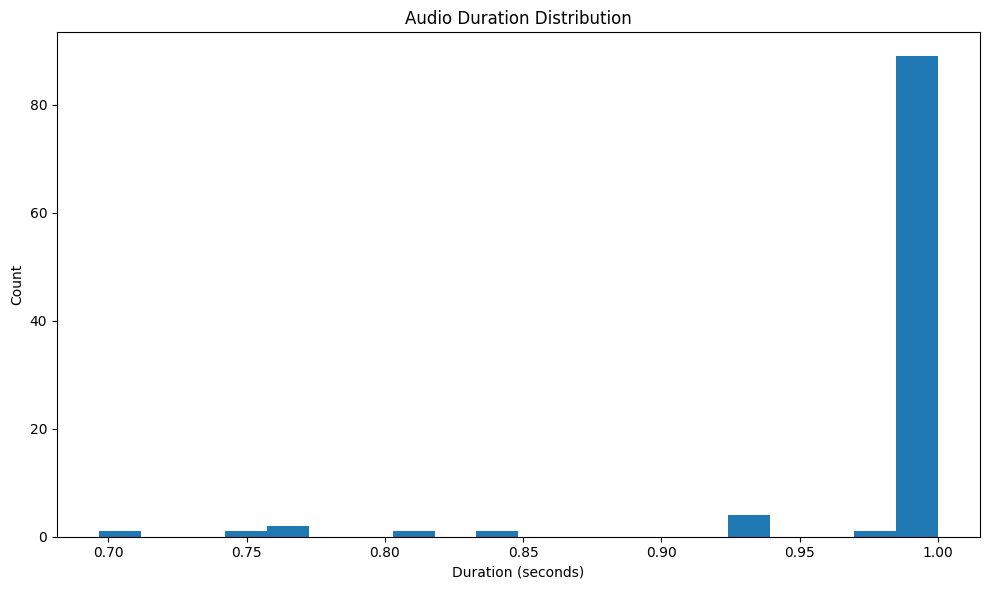


Preprocessing audio files...


100%|██████████| 2000/2000 [00:37<00:00, 53.89it/s]



Visualizing preprocessing for a random yes sample:


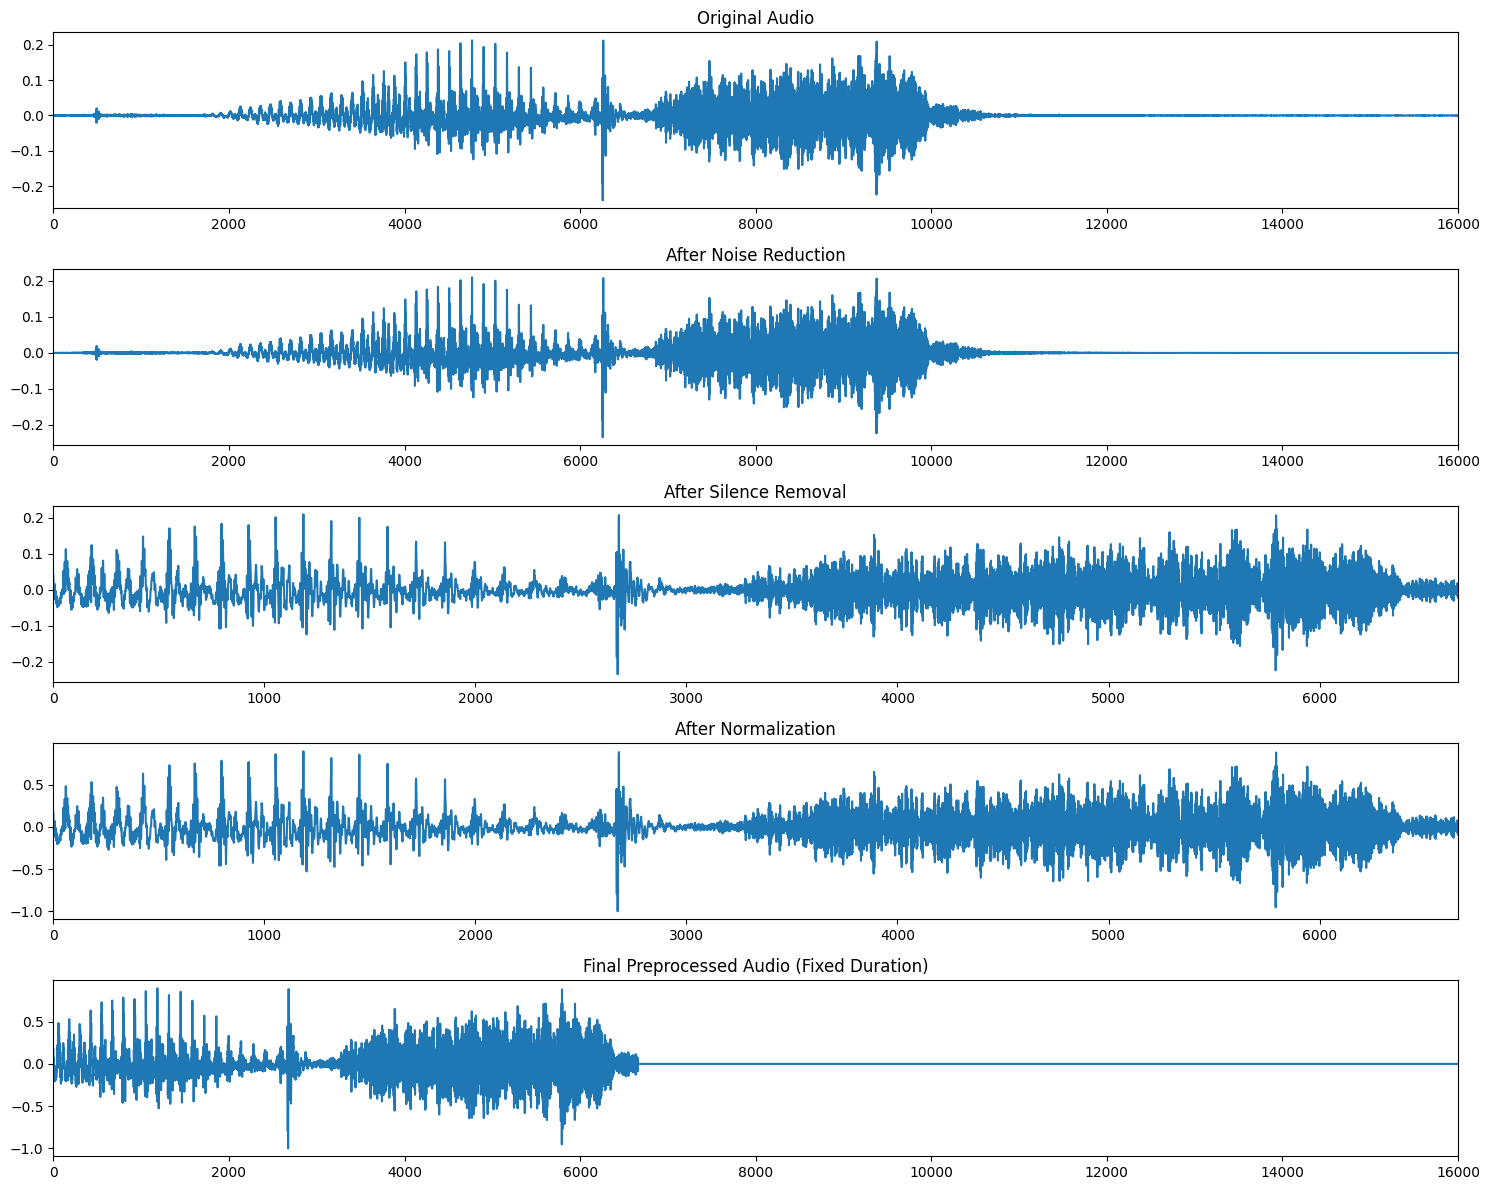

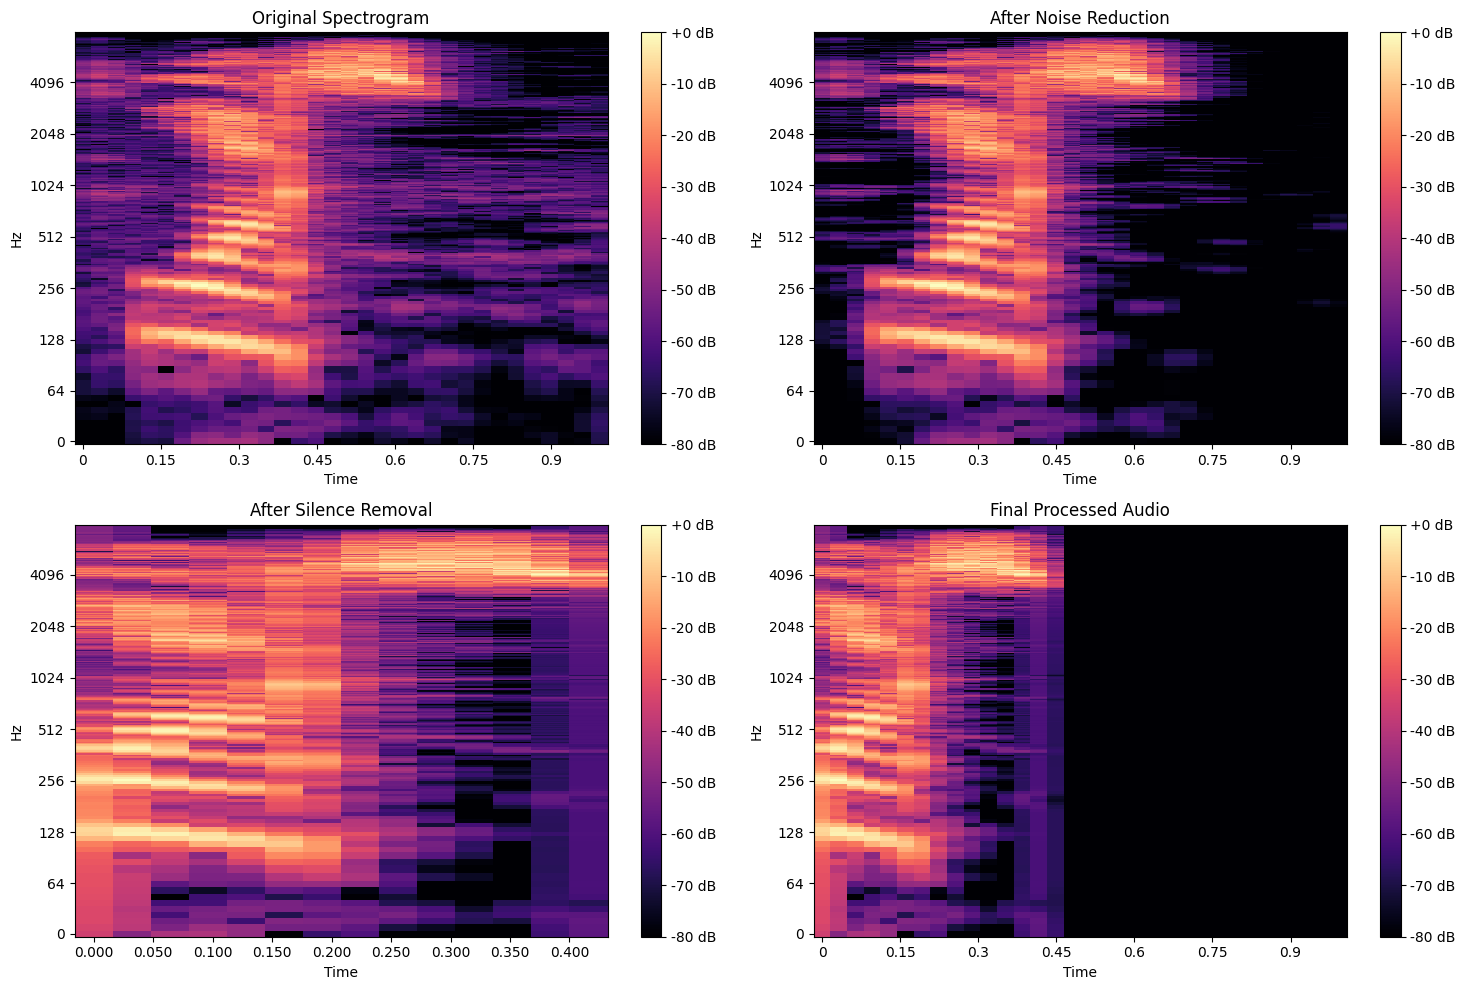

Original Audio:


Processed Audio:


Extracting features from audio files...


 13%|█▎        | 253/2000 [00:19<00:48, 36.16it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 2000/2000 [01:07<00:00, 29.74it/s]



Visualizing extracted features:


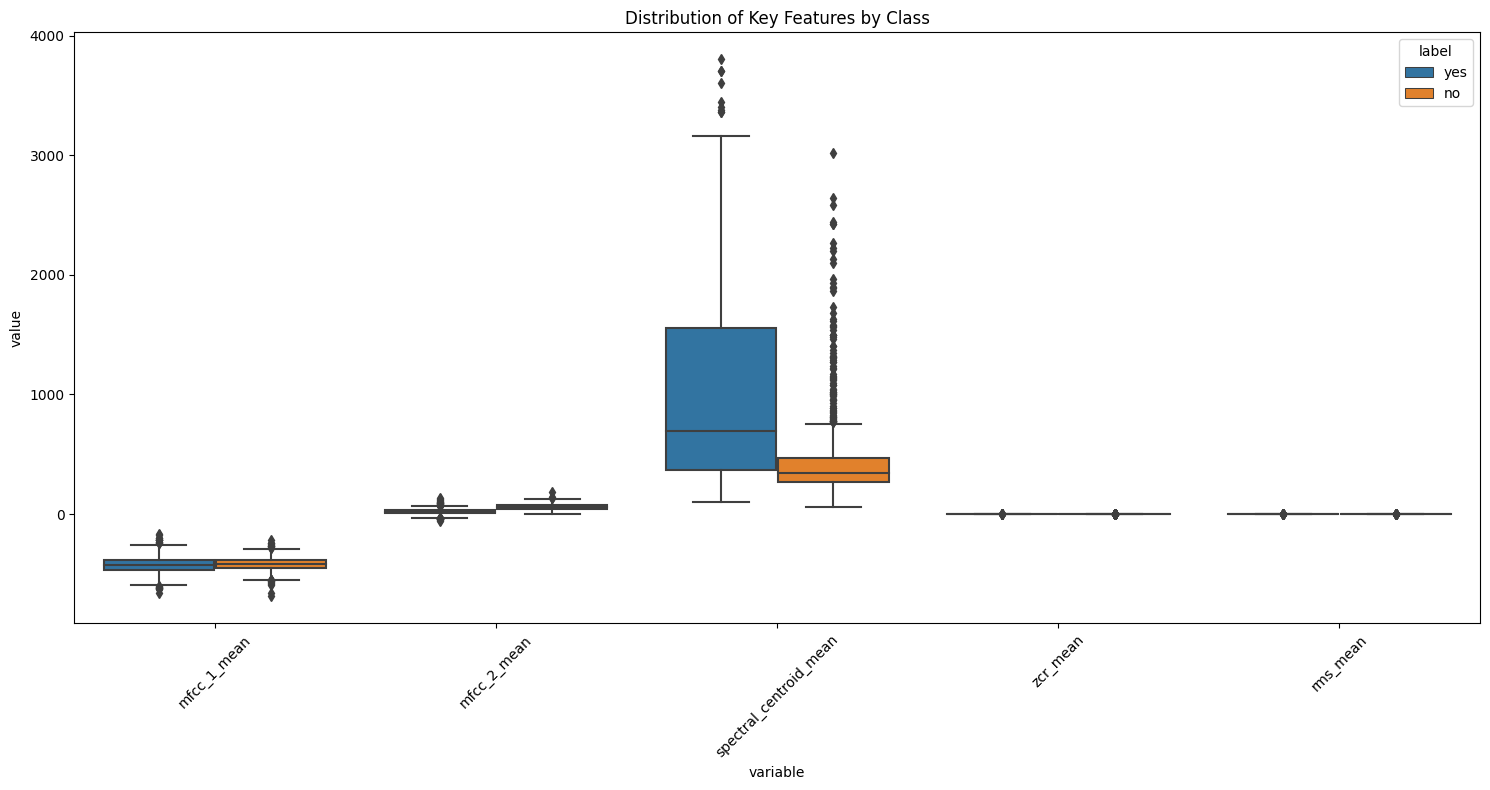

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


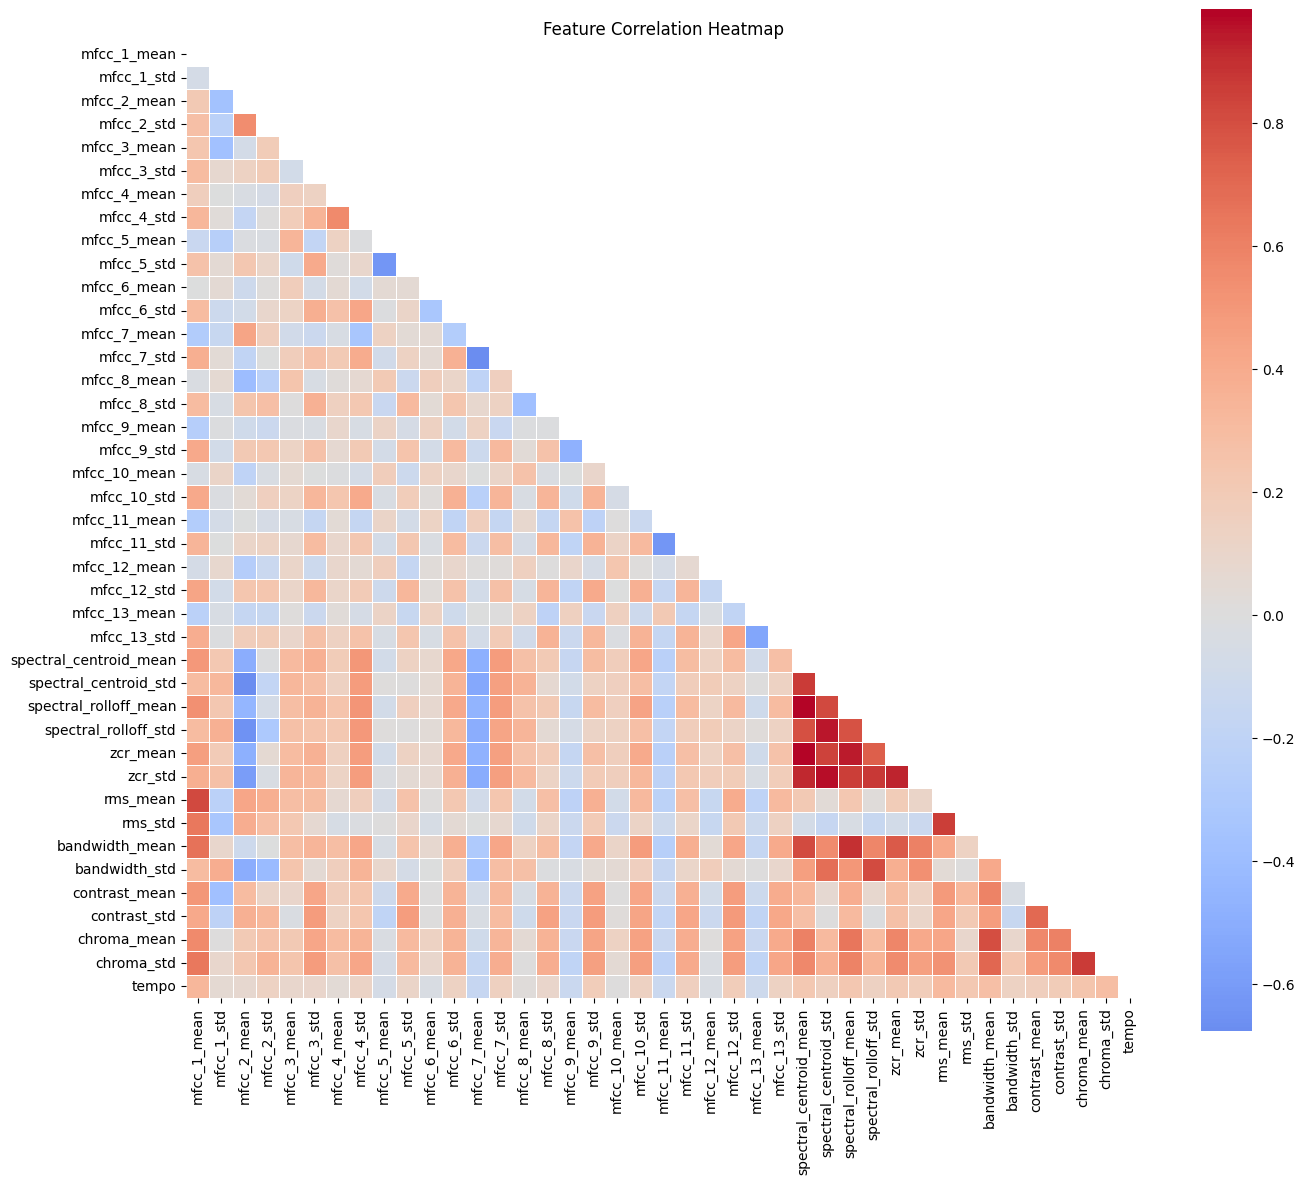

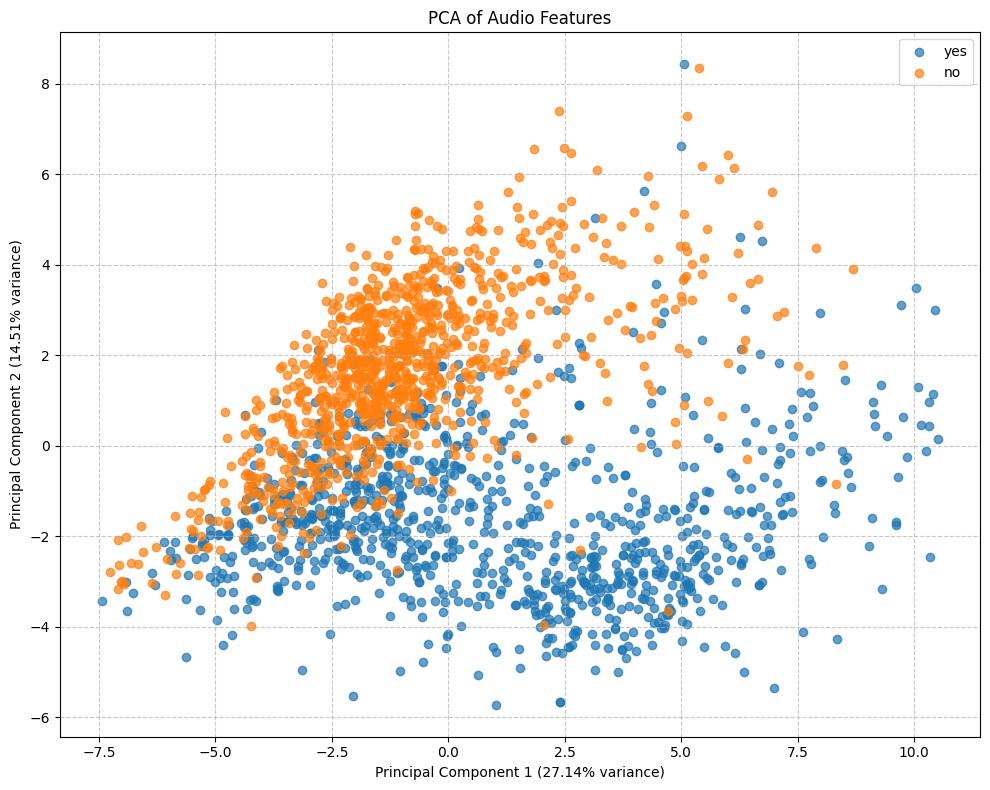


Data split: 1600 training samples, 400 testing samples


In [75]:
system.load_and_preprocess_data()

### Train models

In [76]:
system.train_models(n_estimators=10)


1. Training Naive Bayes Classifier from scratch...

2. Training Bagging with Naive Bayes...
Training 10 models for bagging...


100%|██████████| 10/10 [00:00<00:00, 435.61it/s]



3. Training Logistic Regression from scratch...

4. Training Bagging with Logistic Regression...
Training 10 models for bagging...


100%|██████████| 10/10 [00:00<00:00, 12.58it/s]


### Evaluate models


Evaluating Naive Bayes...
Accuracy: 0.8375
Precision: 0.8508
Recall: 0.8375
F1 Score: 0.8359

Confusion Matrix:
[[187  13]
 [ 52 148]]


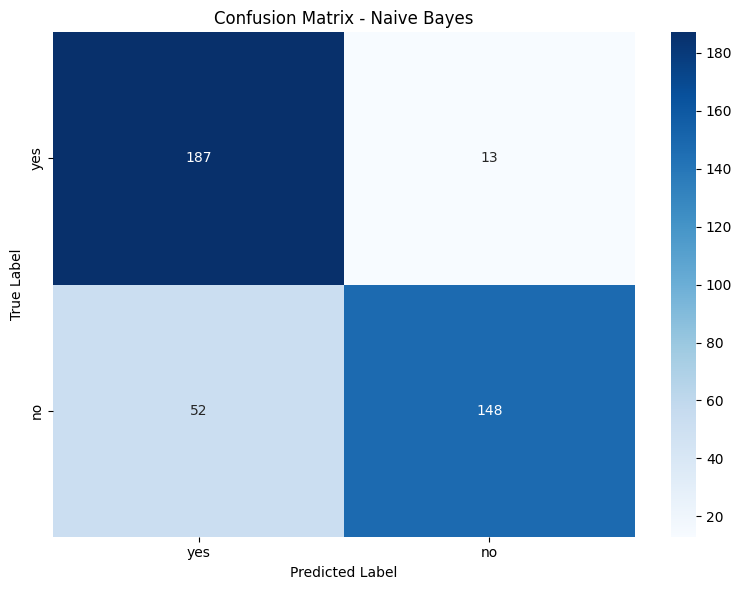


Classification Report:
              precision    recall  f1-score   support

          no       0.78      0.94      0.85       200
         yes       0.92      0.74      0.82       200

    accuracy                           0.84       400
   macro avg       0.85      0.84      0.84       400
weighted avg       0.85      0.84      0.84       400


Evaluating Bagging with Naive Bayes...
Accuracy: 0.8350
Precision: 0.8490
Recall: 0.8350
F1 Score: 0.8333

Confusion Matrix:
[[187  13]
 [ 53 147]]


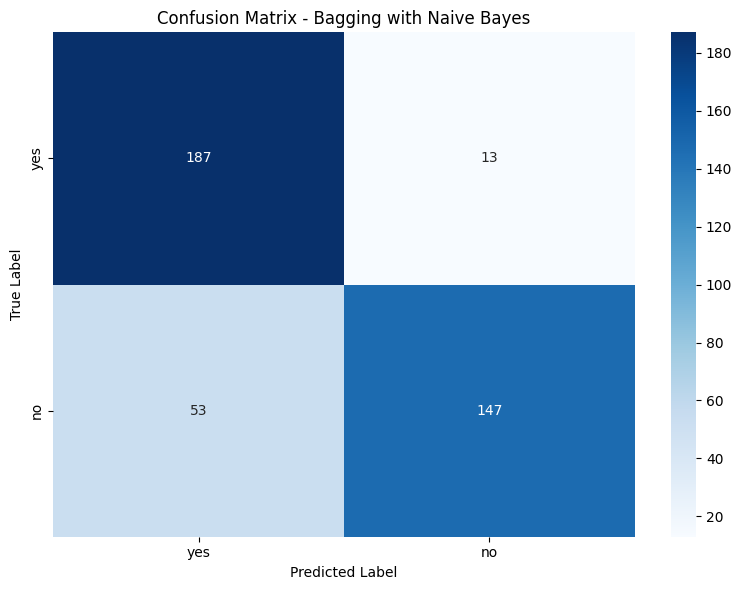


Classification Report:
              precision    recall  f1-score   support

          no       0.78      0.94      0.85       200
         yes       0.92      0.73      0.82       200

    accuracy                           0.83       400
   macro avg       0.85      0.83      0.83       400
weighted avg       0.85      0.83      0.83       400


Evaluating Logistic Regression...
Accuracy: 0.8800
Precision: 0.8810
Recall: 0.8800
F1 Score: 0.8799

Confusion Matrix:
[[181  19]
 [ 29 171]]


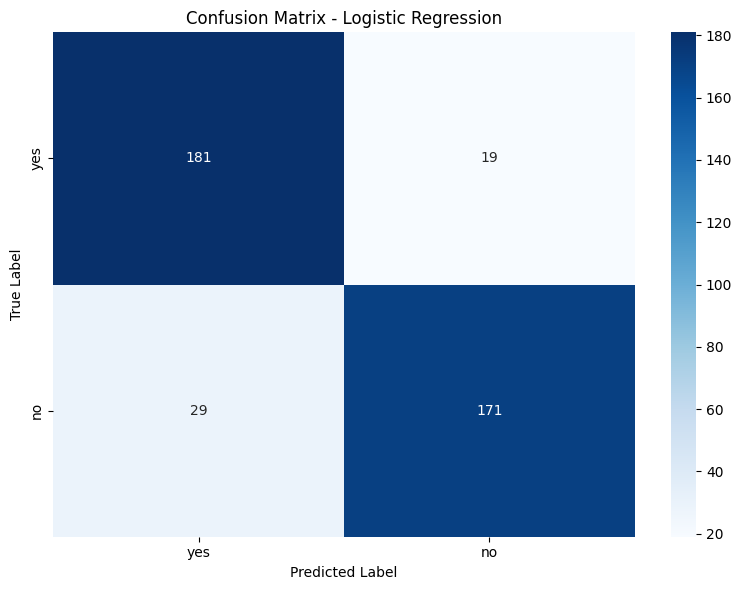


Classification Report:
              precision    recall  f1-score   support

          no       0.86      0.91      0.88       200
         yes       0.90      0.85      0.88       200

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400


Evaluating Bagging with Logistic Regression...
Accuracy: 0.9200
Precision: 0.9200
Recall: 0.9200
F1 Score: 0.9200

Confusion Matrix:
[[185  15]
 [ 17 183]]


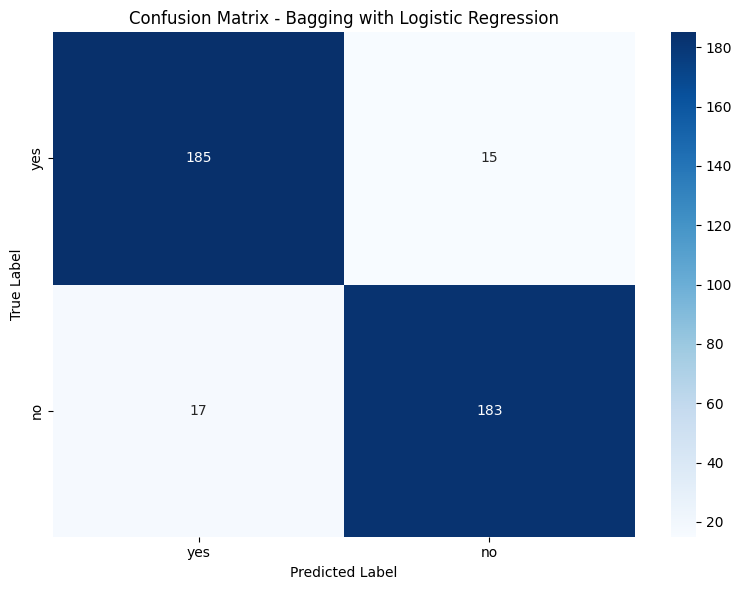


Classification Report:
              precision    recall  f1-score   support

          no       0.92      0.93      0.92       200
         yes       0.92      0.92      0.92       200

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400



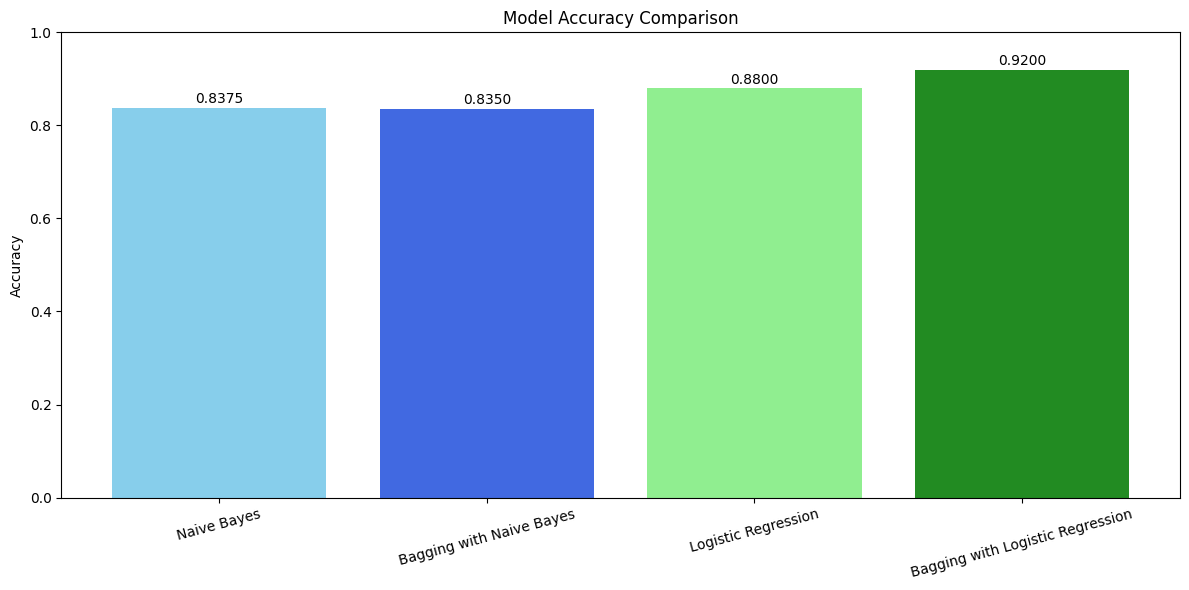

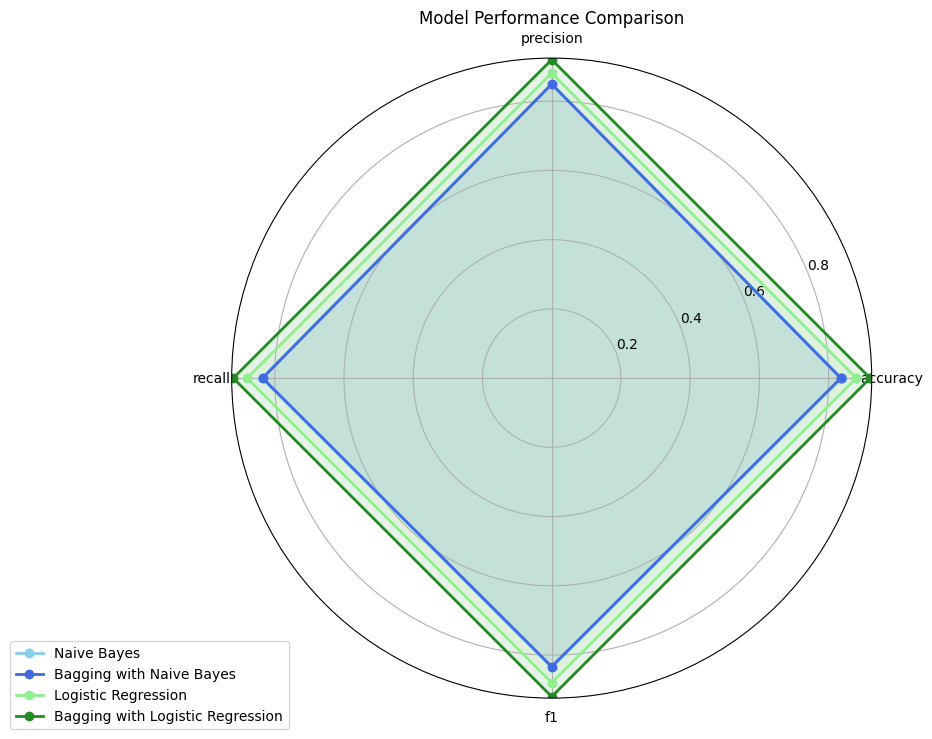

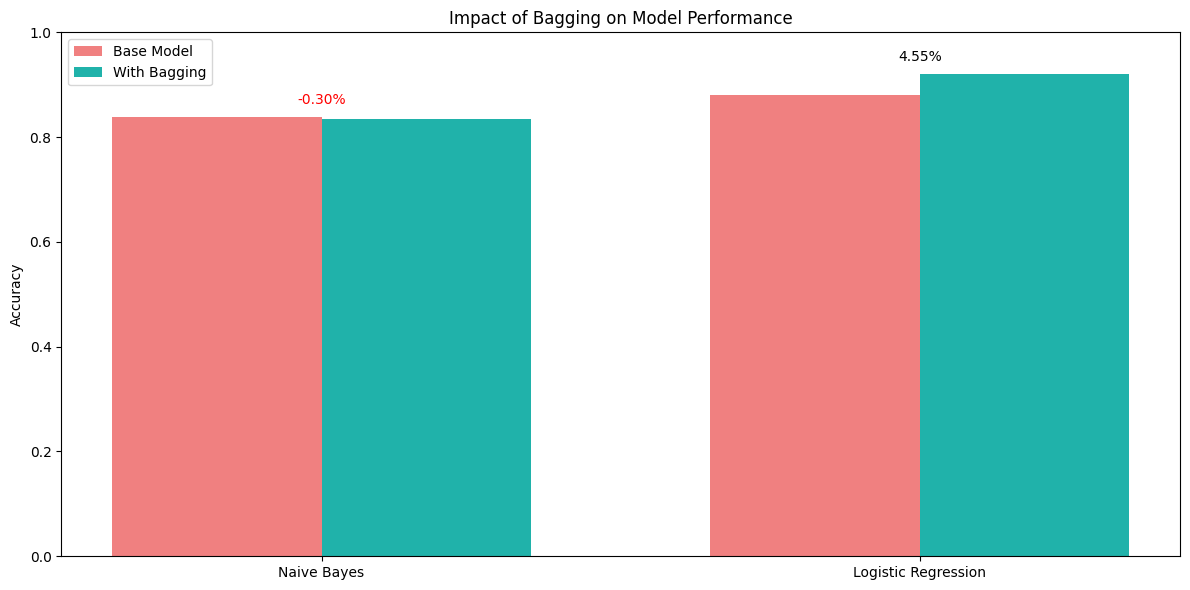


Visualizing Naive Bayes model...


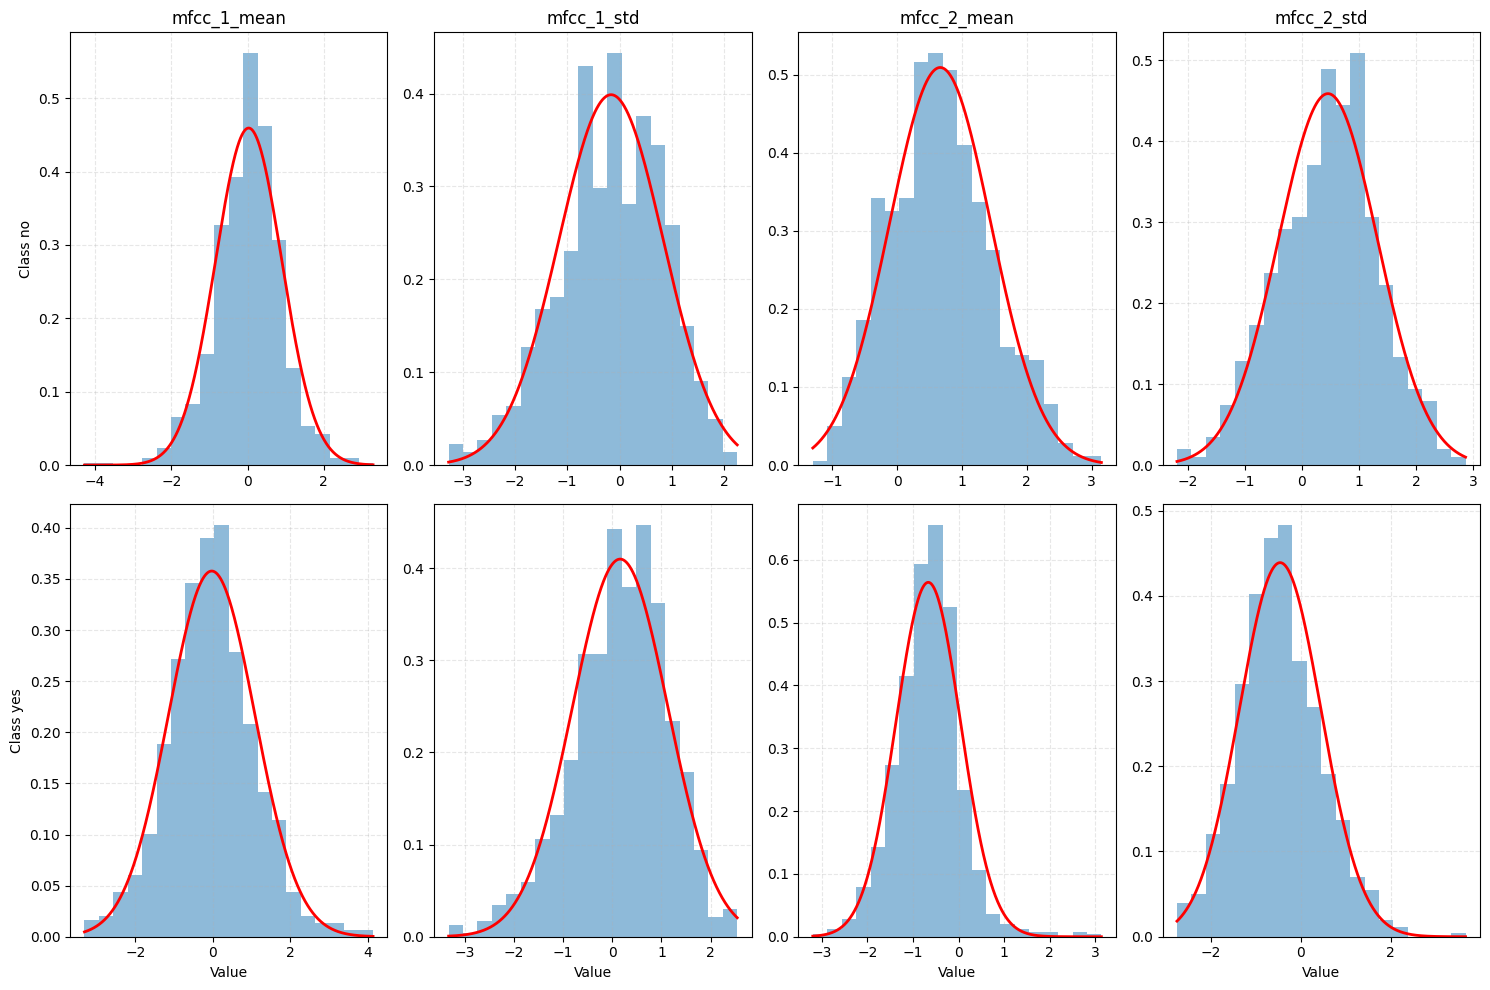

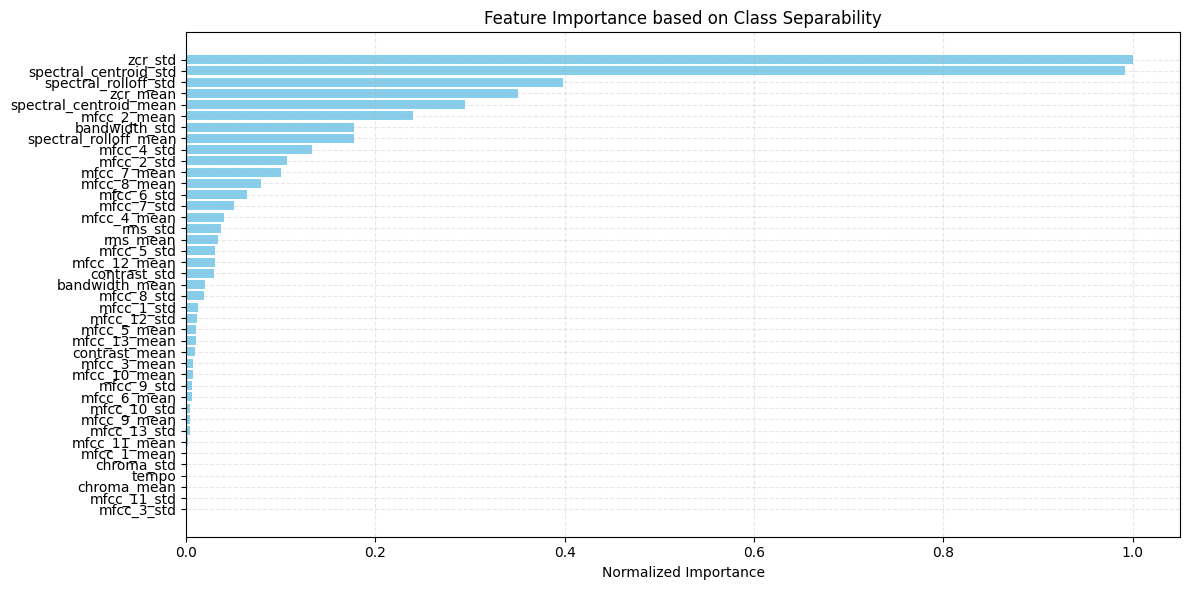

{'Naive Bayes': {'accuracy': 0.8375,
  'precision': 0.8508407183138854,
  'recall': 0.8375,
  'f1': 0.8359404085083827},
 'Bagging with Naive Bayes': {'accuracy': 0.835,
  'precision': 0.8489583333333335,
  'recall': 0.835,
  'f1': 0.8333333333333333},
 'Logistic Regression': {'accuracy': 0.88,
  'precision': 0.880952380952381,
  'recall': 0.88,
  'f1': 0.8799249530956849},
 'Bagging with Logistic Regression': {'accuracy': 0.92,
  'precision': 0.9200420042004199,
  'recall': 0.92,
  'f1': 0.9199979999499988}}

In [77]:
system.evaluate_models()

## User Interaction Phase

In [78]:
# Interactive mode - allowing user to test with their own voice
print("\n==== Welcome to The Speech Recognition & Classification System ====")
print("You can now test the system with your voice!")

while True:
  choice = input(
      "\nChoose an option:\n1. Test with your voice\n2. Test with an audio file\n3. Exit\nYour choice: ")
  if choice == '1':
    duration = float(
        input("Enter recording duration in seconds (default: 1.0): ") or 1.0)
    system.run_live(duration=duration)
  elif choice == '2':
    file_path = input("Enter the path to the audio file: ")
    if os.path.exists(file_path):
      system.run_from_file(file_path)
    else:
      print(f"File {file_path} not found.")
  elif choice == '3':
    print("Exiting...")
    break
  else:
    print("Invalid choice ... Please try again!")


==== Welcome to The Speech Recognition & Classification System ====
You can now test the system with your voice!



Choose an option:
1. Test with your voice
2. Test with an audio file
3. Exit
Your choice:  2
Enter the path to the audio file:  x.wav


File x.wav not found.



Choose an option:
1. Test with your voice
2. Test with an audio file
3. Exit
Your choice:  1
Enter recording duration in seconds (default: 1.0):  3


Recording for 3.0 seconds...


NameError: name 'pyaudio' is not defined